# Preparing for Machine Learning.py

### 1. Data Pre-processing and Visualization

In [2]:
import numpy as np
import pandas as pd

### Missing values

In [3]:
loan_data = pd.read_csv('data/chap06/loan_missing.csv')

In [5]:
# Print missing values
print(loan_data.isna().sum())

Current Loan Amount                0
Credit Score                    1425
Years in current job               0
Annual Income                      0
Monthly Debt                       0
Years of Credit History            0
Months since last delinquent       0
Number of Open Accounts            0
Number of Credit Problems          0
Current Credit Balance             0
Maximum Open Credit                0
Bankruptcies                       0
Tax Liens                          0
dtype: int64


In [6]:
# Drop rows with missing values
dropNArows = loan_data.dropna(axis=0)
print(dropNArows.shape[0]/loan_data.shape[0] * 100)

# Drop columns with missing values
dropNAcols = loan_data.dropna(axis=1)
print(dropNAcols.shape[1]/loan_data.shape[1] * 100, '\n')

71.5
92.3076923076923 



In [7]:
# Fill missing values with zero
loan_data_filled = loan_data.fillna(0)
print(loan_data['Credit Score'].describe())
print(loan_data_filled['Credit Score'].describe())

count    3575.000000
mean      726.868531
std        13.455373
min       700.000000
25%       716.000000
50%       728.000000
75%       738.000000
max       751.000000
Name: Credit Score, dtype: float64
count    5000.000000
mean      519.711000
std       328.348935
min         0.000000
25%         0.000000
50%       719.000000
75%       735.000000
max       751.000000
Name: Credit Score, dtype: float64


In [8]:
# Simple imputation

from sklearn.impute import SimpleImputer

# Subset numeric features
numeric_cols = loan_data.select_dtypes(include=[np.number])

# Impute with mean
imp_mean = SimpleImputer(strategy='mean')
loans_imp_mean = imp_mean.fit_transform(numeric_cols)

# Convert returned array to DataFrame
loans_imp_meanDF = pd.DataFrame(loans_imp_mean, columns=numeric_cols.columns)
print(loans_imp_meanDF['Credit Score'].describe())

count    5000.000000
mean      726.868531
std        11.377097
min       700.000000
25%       721.000000
50%       726.868531
75%       735.000000
max       751.000000
Name: Credit Score, dtype: float64


In [9]:
# Iterative imputation

# Explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Subset numeric features: numeric_cols
numeric_cols = loan_data.select_dtypes(include=[np.number])

# Iteratively impute
imp_iter = IterativeImputer(max_iter=5, sample_posterior=True, random_state=123)
loans_imp_iter = imp_iter.fit_transform(numeric_cols)

# Convert returned array to DataFrame
loans_imp_iterDF = pd.DataFrame(loans_imp_iter, columns=numeric_cols.columns)

# Check the DataFrame's info
print(loans_imp_iterDF['Credit Score'].describe())

count    5000.000000
mean      726.571362
std        13.313343
min       679.050510
25%       716.412105
50%       727.310815
75%       737.000000
max       762.422352
Name: Credit Score, dtype: float64


### Data distribution & transformation

poor model performance can result if the distributions of training and test datasets differ.

In [13]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [11]:
loan_data = pd.read_csv('data/chap06/loan_missing_filled.csv')
loan_data.loc[loan_data['Current Loan Amount'] == 0, 'Loan Status'] = 'Fully Paid'
loan_data.loc[loan_data['Current Loan Amount'] != 0, 'Loan Status'] = 'Charged Off'
loan_data_subset = loan_data[['Credit Score','Annual Income','Loan Status']]

In [12]:
# Create train and test sets
trainingSet, testSet = train_test_split(loan_data_subset, test_size=0.2, random_state=123)

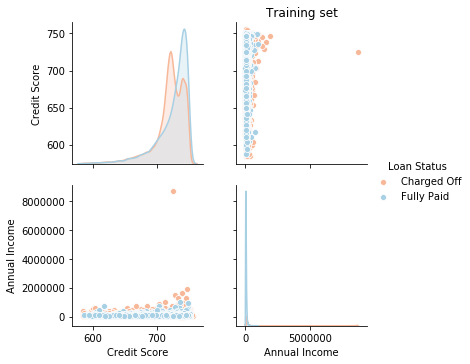

In [17]:
# Examine pairplots
sns.pairplot(trainingSet, hue='Loan Status', palette='RdBu')
plt.title('Training set')
plt.show()

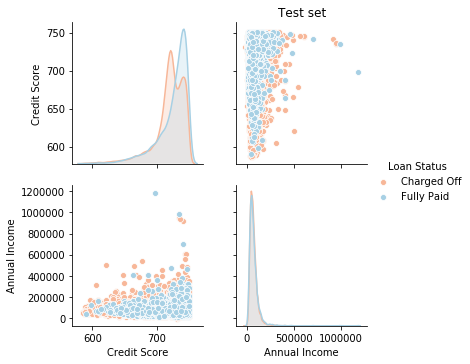

In [18]:
sns.pairplot(testSet, hue='Loan Status', palette='RdBu')
plt.title('Test set')
plt.show()

In [19]:
# Log and power transformations

from scipy import stats
from scipy.stats import mstats

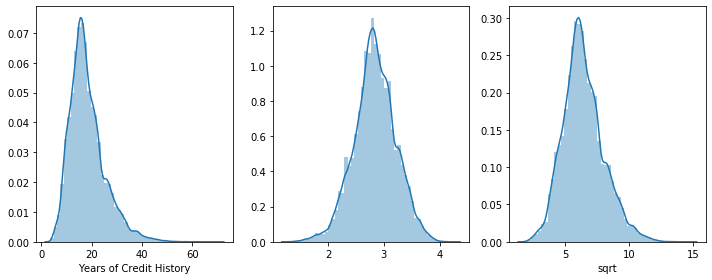

In [29]:
fig, ax = plt.subplots(1,3, figsize=(10, 4))

cr_yrs = loan_data['Years of Credit History']
sns.distplot(cr_yrs, ax=ax[0])

# log transformation
cr_yrs_log = stats.boxcox(cr_yrs, lmbda=0.0)
sns.distplot(cr_yrs_log, ax=ax[1])
plt.xlabel('log')

# Square root transform
cr_yrs_sqrt = stats.boxcox(cr_yrs, lmbda=0.5)
sns.distplot(cr_yrs_sqrt, ax=ax[2])
plt.xlabel('sqrt')
plt.tight_layout()
plt.show()

### Outlier handling

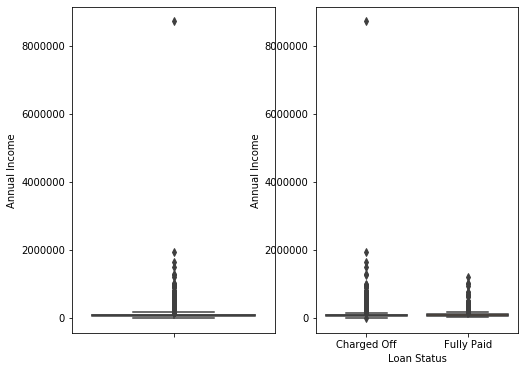

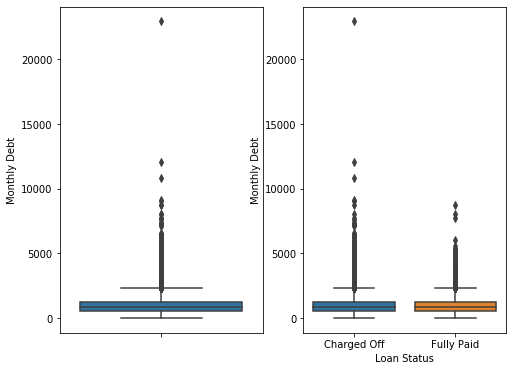

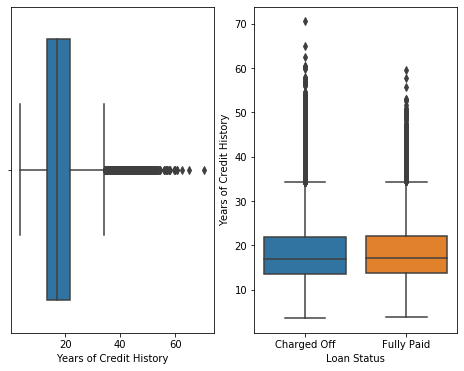

In [30]:
# Outlier detection
# Inter-quartile range (IQR)

fig, ax = plt.subplots(1,2, figsize=(8, 6))
sns.boxplot(y=loan_data['Annual Income'], ax=ax[0])
sns.boxplot(x='Loan Status', y='Annual Income', data=loan_data, ax=ax[1])
plt.show()

fig, ax = plt.subplots(1,2, figsize=(8, 6))
sns.boxplot(y=loan_data['Monthly Debt'], ax=ax[0])
sns.boxplot(x='Loan Status', y='Monthly Debt', data=loan_data, ax=ax[1])
plt.show()

fig, ax = plt.subplots(1,2, figsize=(8, 6))
sns.boxplot(x=loan_data['Years of Credit History'], ax=ax[0])
sns.boxplot(x='Loan Status', y='Years of Credit History', data=loan_data, ax=ax[1])
plt.show()

In [31]:
# Handling outliers

numeric_cols = loan_data.select_dtypes(include=[np.number])
categoric_cols = loan_data.select_dtypes(include=object)

print(numeric_cols['Monthly Debt'].describe())

count    88910.000000
mean       963.102059
std        637.524064
min          0.000000
25%        532.220000
50%        843.925000
75%       1250.527500
max      22939.120000
Name: Monthly Debt, dtype: float64


In [32]:
# ver 1 - zscore

# Create index of rows to keep (inner 3sigma)
idx = (np.abs(stats.zscore(numeric_cols)) < 3).all(axis=1)
# Concatenate numeric and categoric subsets
ld_out_drop = pd.concat([numeric_cols.loc[idx], categoric_cols.loc[idx]], axis=1)

print(ld_out_drop['Monthly Debt'].describe())

count    80624.000000
mean       907.364200
std        530.022029
min          0.000000
25%        519.357500
50%        821.385000
75%       1204.790000
max       2875.310000
Name: Monthly Debt, dtype: float64


In [33]:
# ver 2 - mstats.winsorize

# Winsorize numeric columns (5% upper and lower limits)
debt_win = mstats.winsorize(loan_data['Monthly Debt'], limits=[0.05, 0.05])
# Convert to DataFrame, reassign column name
debt_out = pd.DataFrame(debt_win, columns=['Monthly Debt'])

print(debt_out['Monthly Debt'].describe())

count    88910.000000
mean       935.371257
std        524.958889
min        193.460000
25%        532.220000
50%        843.925000
75%       1250.527500
max       2115.520000
Name: Monthly Debt, dtype: float64


Standardization vs. Normalization

* Standardization
    - z-score standardization
    - scles to mean 0 & std 1

* Normalization
    - Min/max normalization
    - scales to 0 ~ 1 range

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit and transform, convert to DF
numeric_cols_scaled = scaler.fit_transform(numeric_cols)
numeric_cols_scaledDF = pd.DataFrame(numeric_cols_scaled, columns=numeric_cols.columns)

# Concatenate categoric columns to scaled numeric columns
final_DF = pd.concat([numeric_cols_scaledDF, categoric_cols], axis=1)
print(final_DF.head())

   Current Loan Amount  Credit Score  Years in current job  Annual Income  \
0             0.032520      0.281670             -1.312259      -0.493295   
1             1.444549      0.488729              1.189261       0.157771   
2             0.461696      0.116023              0.911314      -0.232631   
3            -0.024483      0.778611             -0.756366      -0.728961   
4            -0.237359     -1.457623              1.189261      -0.486493   

   Monthly Debt  Years of Credit History  Months since last delinquent  \
0     -0.291304                -0.044731                     -1.681931   
1     -0.111388                 1.189463                     -0.042509   
2      0.440641                -0.229151                     -0.235202   
3      0.043666                -1.179622                      0.142336   
4     -0.720592                -0.229151                     -0.695525   

   Number of Open Accounts  Number of Credit Problems  Current Credit Balance  \
0          

## 2. Supervised Learning

1. Selecting the correct features 
    - Reduces overfitting
    - Improve accuracy
    - Increase interpretability
    - Reduces training time.


2. Feature selection methods
    - Filter: Rank features based on statistical performance
    - Wrapper: Use an ML method to evaluate performance
    - Embedded: Iterative model training to extract features
    - Feature importance: tree-based ML models`

Correlation coefficient statistical tests<br>
    
    feature/target    continuous                 categorical
    continuous        Pearsons Correlation       LDA
    categorical       ANOVA                      Chi-Square

### Filter and wrapper methods

In [39]:
diabetes = pd.read_csv('data/chap06/diabetes.csv')

# Create correlation matrix and print it
cor = diabetes.corr()
print(cor)

                  age       sex       bmi        bp        s1        s2  \
age          1.000000  0.173737  0.185085  0.335427  0.260061  0.219243   
sex          0.173737  1.000000  0.088161  0.241013  0.035277  0.142637   
bmi          0.185085  0.088161  1.000000  0.395415  0.249777  0.261170   
bp           0.335427  0.241013  0.395415  1.000000  0.242470  0.185558   
s1           0.260061  0.035277  0.249777  0.242470  1.000000  0.896663   
s2           0.219243  0.142637  0.261170  0.185558  0.896663  1.000000   
s3          -0.075181 -0.379090 -0.366811 -0.178761  0.051519 -0.196455   
s4           0.203841  0.332115  0.413807  0.257653  0.542207  0.659817   
s5           0.270777  0.149918  0.446159  0.393478  0.515501  0.318353   
s6           0.301731  0.208133  0.388680  0.390429  0.325717  0.290600   
progression  0.187889  0.043062  0.586450  0.441484  0.212022  0.174054   

                   s3        s4        s5        s6  progression  
age         -0.075181  0.203841 

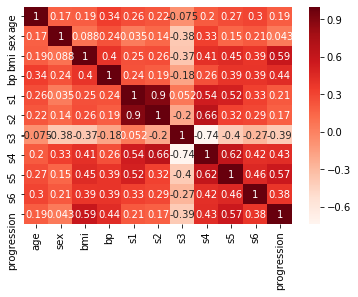

In [40]:
# Correlation matrix heatmap
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [41]:
# Correlation with output variable
cor_target = abs(cor["progression"])

# Selecting highly correlated features
best_features = cor_target[cor_target > 0.5]
print(best_features)

bmi            0.586450
s5             0.565883
progression    1.000000
Name: progression, dtype: float64


In [42]:
from sklearn.svm import SVR
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LarsCV

y = diabetes.pop('progression')
X = diabetes

# Instantiate estimator and feature selector
svr_mod = SVR(kernel="linear")
feat_selector = RFECV(svr_mod, cv=5)

feat_selector = feat_selector.fit(X, y)

print(feat_selector.support_)
print(feat_selector.ranking_)
print(X.columns)

[ True False  True  True  True  True  True  True  True  True]
[1 2 1 1 1 1 1 1 1 1]
Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], dtype='object')


In [43]:
# Drop feature suggested not important in step 2
X = X.drop('sex', axis=1)

# Fit
lars_mod = LarsCV(cv=5, normalize=False)
feat_selector = lars_mod.fit(X, y)

# Print r-squared score and estimated alpha
print(lars_mod.score(X, y))
print(lars_mod.alpha_)

0.4982900996498095
0.052268622851592804


### Feature selection through feature importance

In [44]:
from sklearn.ensemble import RandomForestRegressor

rf_mod = RandomForestRegressor(max_depth=2, n_estimators=100, oob_score=True, random_state=123)
rf_mod.fit(X, y)

print(diabetes.columns)
print(rf_mod.feature_importances_)

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], dtype='object')
[0.         0.39961579 0.03085607 0.         0.00128948 0.00700339
 0.00417891 0.53899467 0.01806168]


In [46]:
from sklearn.ensemble import ExtraTreesRegressor

xt_mod = ExtraTreesRegressor(n_estimators=100)
xt_mod.fit(X, y)

print(diabetes.columns)
print(xt_mod.feature_importances_)

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], dtype='object')
[0.06099488 0.28169523 0.10706861 0.04897553 0.05883461 0.06661744
 0.07533309 0.21884434 0.08163627]


### Regularization

Lasso uses the L1 norm corresponding to the penalty parameter and the absolute value of the coefficients.


Ridge regression performs L2 regularization, which adds a penalty term to ordinary least squares using the penalty parameter and the sum of the squared coefficients.

In [47]:
# Lasso regularization

from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.3)

# Instantiate cross-validated lasso, fit
lasso_cv = LassoCV(alphas=None, cv=10, max_iter=10000)
lasso_cv.fit(X_train, y_train) 

# Instantiate lasso, fit, predict and print MSE
lasso = Lasso(alpha = lasso_cv.alpha_)
lasso.fit(X_train, y_train)

print(mean_squared_error(y_true=y_test, y_pred=lasso.predict(X_test)))

2977.4320945626737


In [48]:
# Ridge regularization

# Import modules
from sklearn.linear_model import Ridge, RidgeCV

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.3)

# Instantiate cross-validated ridge, fit
ridge_cv = RidgeCV(alphas=np.logspace(-6, 6, 13))
ridge_cv.fit(X_train, y_train)

# Instantiate ridge, fit, predict and print MSE
ridge = Ridge(alpha = ridge_cv.alpha_)
ridge.fit(X_train, y_train)

print(mean_squared_error(y_true=y_test, y_pred=ridge.predict(X_test)))

3037.383332513441
